# TODO

Exploratory Data Analysis
- [X] Maybe make a pairplot?
- [ ] [Camila] Compute and plot the correlation between features
- [ ] [Camila] Analyze Null values -> There are none, but we need to write about it
- [ ] [Camila] Check outliers
- [ ] [Camila] Take care of the Lat/Long variables (how are we going to use them?)

Pre-Modeling
- [X] Split the data into train and test
- [X] Decide what are our target variable(s)
- [X] Create the grid search for hyper parameter optimization and model selection
- [ ] Apply PCA to see if we can benefit from it (Low prio)

Modeling
- [X] [Dio] Check Feature Selection
- [ ] Try to build a classifier (Low prio)
- [ ] [Dio] Feature Importance

Post-modeling
- [ ] [Camila] Plot residuals

# Notes

- [Link to paper](https://zenodo.org/records/4446043)

# Airbnb: Amsterdam x Paris

In [1]:
# !pip install ydata_profiling ipywidgets

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from sklearn import preprocessing
from sklearn import svm
from sklearn import model_selection
from sklearn import linear_model
from sklearn import pipeline
from sklearn import ensemble
from sklearn import compose
from sklearn import feature_selection
from sklearn import neural_network
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression,Perceptron
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier



/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
SEED = 13
TEST_DATASET_RATIO = 0.3
RAW_DATA_PATH = '../raw_data'
DTYPES = {
    'realSum':                    'float64',
    'room_type':                  'category',  # Three possible categories: ['Entire home/apt', 'Private room', 'Shared room']
    'room_shared':                'bool',
    'room_private':               'bool',
    'person_capacity':            'int8',
    'host_is_superhost':          'bool',
    'multi':                      'bool',  # multi seems to be a boolean variable.
    'biz':                        'bool',  # biz seems to be a boolean variable.
    'cleanliness_rating':         'int8',
    'guest_satisfaction_overall': 'int16',
    'bedrooms':                   'int8',
    'dist':                       'float64',
    'metro_dist':                 'float64',
    'attr_index':                 'float64',
    'attr_index_norm':            'float64',
    'rest_index':                 'float64',
    'rest_index_norm':            'float64',
    'lng':                        'float64',
    'lat':                        'float64'
}

In [4]:
np.random.seed(SEED)

In [5]:
def _read_csv(path: str) -> pd.DataFrame:
    """
    Helper function to read csv's, set their index properly and convert the datatypes here accordingly.
    Many times the automatic detection was using Int64 for variables with a small range of values (like `person_capacity`),
    using integeres instead of booleans (for `multi` and `biz`) or not using the categorical datatype (`room_type`).
    """
    return pd.read_csv(
        path,
        index_col=0,
        dtype=DTYPES
    )


def _read_city(city: str) -> pd.DataFrame:
    """
    Helper function to generate a merged dataframe for a specified @city.
    It combines the weekdays and the weekends data into a single dataframe.
    """
    assert city in ['amsterdam', 'paris'], "ERROR: Invalid city. Options are 'amsterdam' or 'paris'"
    
    weekday_path = f"{RAW_DATA_PATH}/{city}_weekdays.csv"
    weekday = _read_csv(weekday_path)
    weekday['is_weekend'] = False

    weekend_path = f"{RAW_DATA_PATH}/{city}_weekends.csv"
    weekend = _read_csv(weekend_path)
    weekend['is_weekend'] = True

    merged = pd.concat([weekday, weekend])
    merged['city'] = city

    return merged.reset_index(drop=True)


def get_merged_df() -> pd.DataFrame:
    """
    Reads the data from both files (weekends and weekdays) and both cities (Amsterdam and Paris) and merge them into a single dataframe.
    It also corrects the datatypes and sets the index properly.
    """
    amsterdam = _read_city('amsterdam')
    paris = _read_city('paris')
    
    merged = pd.concat([amsterdam, paris])
    merged = merged.reset_index(drop=True)
    merged['city'] = merged['city'].astype("category")
    
    return merged

def categorize_value(value):
   
    quantiles = pd.qcut(merged_df["realSum"], q=3)

   
    unique_intervals = quantiles.unique()

   
    upper_limits = [interval.right for interval in unique_intervals]    


    if value <= upper_limits[0]:
        return "Low"
    elif value <= upper_limits[1]:
        return "Medium"
    else:
        return "High"

def confusion(true, pred):

    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm



In [6]:
merged_df = get_merged_df()

merged_df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,is_weekend,city
0,194.033698,Private room,False,True,2,False,True,False,10,93,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,False,amsterdam
1,344.245776,Private room,False,True,4,False,False,False,8,85,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,False,amsterdam
2,264.101422,Private room,False,True,2,False,False,True,9,87,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,False,amsterdam
3,433.529398,Private room,False,True,4,False,False,True,9,90,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,False,amsterdam
4,485.552926,Private room,False,True,2,True,False,False,10,98,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,False,amsterdam


## Notes
I am stratifying the train-test split by `city` and by `is_weekend`.

# Outliers and Null values

In [7]:
null_values = merged_df.isnull().any()
null_values[null_values == True]

Series([], dtype: bool)

In [8]:
merged_df.groupby("city")["realSum"].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
amsterdam,2080.0,573.112795,430.658406,128.887118,331.825745,460.244183,686.441075,8130.668104
paris,6688.0,392.531403,330.949745,92.739305,240.935782,317.597167,462.065430,16445.614689


In [9]:
th=2300
(merged_df[merged_df["realSum"]<=th].groupby("city")["realSum"].count()/merged_df.groupby("city")["realSum"].count())*100

city
amsterdam    99.230769
paris        99.805622
Name: realSum, dtype: float64

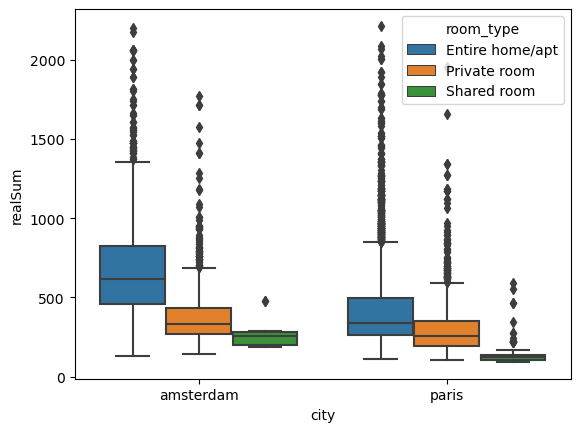

In [10]:

sns.boxplot(x="city", y="realSum",
           hue= "room_type", 
            data=merged_df[merged_df["realSum"]<th])
#plt.axhline(y=4500, color='r', linestyle='--', linewidth=2)
plt.show()
merged_df=merged_df[merged_df["realSum"]<th]

# Exploratory analysis

In [11]:
profile = ProfileReport(merged_df, title="Profiling Report")
# profile

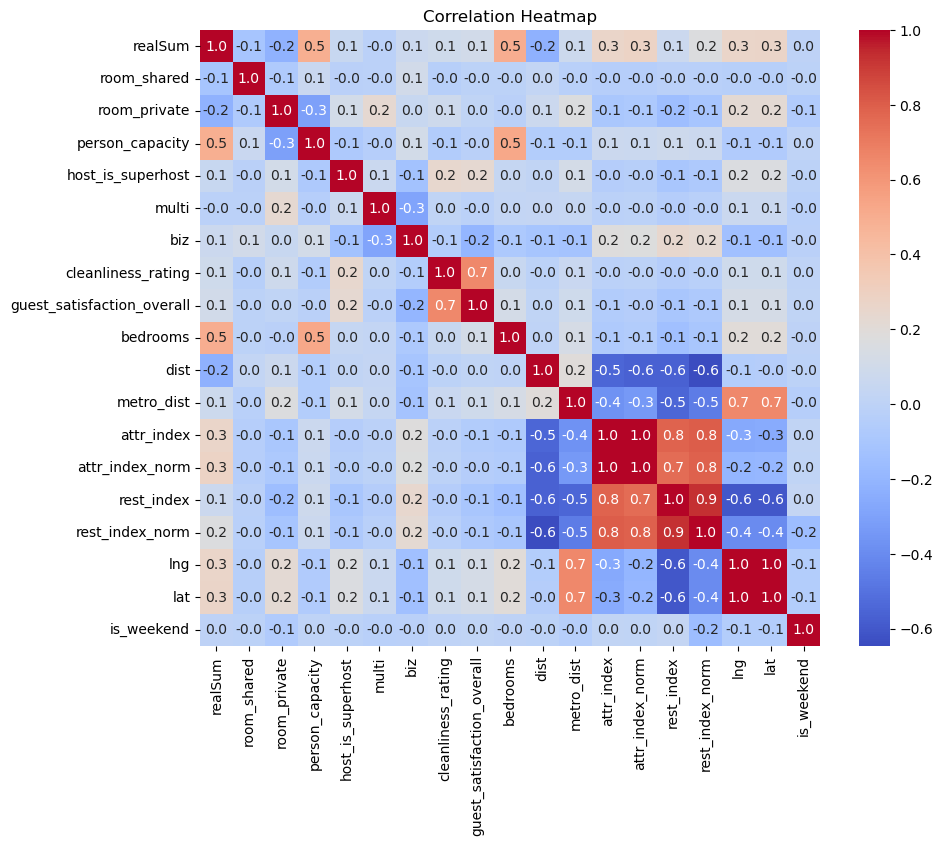

In [12]:
correlation_matrix = merged_df.drop(["room_type","city"],axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

## Train Test Split

In [13]:
X = merged_df.drop('realSum', axis=1)
y = merged_df['realSum']

In [14]:
stratify_col = 2 * preprocessing.LabelEncoder().fit_transform(X['city']) + preprocessing.LabelEncoder().fit_transform(X['is_weekend'])

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=TEST_DATASET_RATIO,
    random_state=SEED,
    shuffle=True,
    stratify=stratify_col
)

In [16]:
y_train

6313     319.694287
2909    1402.740237
6625     565.523348
4615     158.915090
6179     394.025538
           ...     
460     1804.185316
2246     333.209060
4139     417.093858
3474     783.390810
3631     260.741914
Name: realSum, Length: 6117, dtype: float64

In [17]:
X_train

,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,is_weekend,city
6313,Entire home/apt,False,False,2,False,False,False,8,84,1,4.213622,0.222282,483.845420,23.527019,890.820423,41.095623,2.29913,48.87018,True,paris
2909,Entire home/apt,False,False,6,False,False,False,10,91,3,2.018346,0.212487,498.909756,24.286759,933.795181,54.869372,2.32978,48.84657,False,paris
6625,Private room,False,True,5,False,False,True,10,84,1,2.832513,0.215862,414.999827,20.179397,1056.737903,48.749783,2.33831,48.88020,True,paris
4615,Private room,False,True,2,True,False,False,10,95,1,7.178775,0.167550,176.647835,8.599157,348.879865,20.500019,2.25853,48.83914,False,paris
6179,Entire home/apt,False,False,2,False,False,True,8,76,1,3.371657,0.258374,539.082522,26.212927,933.612536,43.069723,2.30680,48.85741,True,paris
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,Entire home/apt,False,False,6,False,True,False,9,94,3,0.433109,0.227969,765.245811,40.520274,793.567194,55.296904,4.89932,52.37405,False,amsterdam
2246,Entire home/apt,False,False,4,False,False,True,9,93,1,2.776628,0.209454,499.312614,24.306370,1051.622479,61.792850,2.32527,48.87375,False,paris
4139,Entire home/apt,False,False,4,False,False,False,10,96,2,2.424140,0.220054,243.649377,11.860770,640.189803,37.617256,2.38579,48.85685,False,paris
3474,Entire home/apt,False,False,6,False,False,True,8,84,2,2.431602,0.369166,268.725685,13.081476,739.603213,43.458742,2.37265,48.87406,False,paris


# Model Training and Selection

In [18]:
columns_to_drop = [
    'attr_index',
    'rest_index',
    'lat',
    'lng',
    'room_shared',
    'room_private',
    'bedrooms'
]

In [19]:
encoder = compose.make_column_transformer(
    (
        'scaler',
        X_train.select_dtypes('number').columns
    ),
    (
        preprocessing.OneHotEncoder(sparse_output=False, drop='first'),
        X_train.select_dtypes('category').columns
    ),
    (
        preprocessing.OneHotEncoder(sparse_output=False, drop='first'),
        X_train.select_dtypes('bool').columns
    ),
    (
        'drop',
        columns_to_drop
    ),
    remainder='passthrough'
)

In [20]:
model = pipeline.Pipeline([
    ('encoder', encoder),
    ('feat_select', None),
    ('regressor', None),
])

In [21]:
parameters = [
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_regression],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "regressor": [linear_model.Ridge()],
        "regressor__alpha": [0.1, 0.5, 1.0]
    },
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_regression],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "regressor": [ensemble.RandomForestRegressor()],
        "regressor__n_estimators": [10, 50, 100],
        "regressor__min_samples_leaf": [1, 5, 10],
        "regressor__max_features": [1, 'sqrt', 'log2'],
    },
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_regression],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "regressor": [neural_network.MLPRegressor()],
        "regressor__max_iter": [1_000],
        "regressor__alpha": [0.001],
        "regressor__learning_rate_init": [0.01],
        "regressor__hidden_layer_sizes": [(2,), (8,), (64,), (256,), (2, 2), (4, 4)]
    },
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_regression],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "regressor": [ensemble.RandomForestRegressor()],
        "regressor__n_estimators": [50],
        # "regressor__min_samples_leaf": [1, 5, 10],
        "regressor__max_features": ['sqrt'],
    },
    {
        'encoder__scaler': [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_regression],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        'regressor': [svm.SVR()],
        'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'regressor__C': [0.1, 1, 10, 100],
        'regressor__gamma': ['scale', 'auto'],
    }
]

In [22]:
%%time
clf = model_selection.GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, verbose=3, n_jobs=-1, error_score='raise')  # Stratified by default
clf.fit(X_train, y_train)

Fitting 5 folds for each of 414 candidates, totalling 2070 fits


/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from

[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=Ridge(), regressor__alpha=0.1;, score=-49735.934 total time=   2.5s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=Ridge(), regressor__alpha=0.5;, score=-54799.589 total time=   3.2s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=Ridge(), regressor__alpha=1.0;, score=-49702.716 total time=   2.2s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4,

[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=Ridge(), regressor__alpha=0.1;, score=-54772.184 total time=   2.4s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=Ridge(), regressor__alpha=0.5;, score=-49712.923 total time=   3.0s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=Ridge(), regressor__alpha=1.0;, score=-54836.932 total time=   2.1s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4,

[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=5, regressor__n_estimators=10;, score=-53930.215 total time=   3.4s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=5, regressor__n_estimators=50;, score=-45290.315 total time=   4.2s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_f

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=5, regressor__n_estimators=10;, score=-52325.763 total time=   2.8s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=5, regressor__n_estimators=50;, score=-52951.481 total time=   4.9s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_f

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=1, regressor__n_estimators=100;, score=-42910.135 total time=   7.9s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=5, regressor__n_estimators=10;, score=-50700.620 total time=   3.1s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=5, regressor__n_estimators=50;, score=-50399.030 total time=   4.5s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=5, regressor__n_estimators=100;, score=-51524.120 total time=   5.9s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=50;, score=-46025.886 total time=   4.9s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=100;, score=-29682.898 total time=   7.5s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor

[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=1, regressor__n_estimators=100;, score=-19265.506 total time=   5.7s[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=5, regressor__n_estimators=10;, score=-34593.411 total time=   2.7s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__m

[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=5, regressor__n_estimators=50;, score=-34773.017 total time=   4.3s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=5, regressor__n_estimators=100;, score=-25834.971 total time=   5.8s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor

[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=1, regressor__n_estimators=100;, score=-23503.736 total time=   5.6s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=5, regressor__n_estimators=10;, score=-23596.371 total time=   3.2s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__m

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=1, regressor__n_estimators=100;, score=-24026.416 total time=   5.5s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=5, regressor__n_estimators=10;, score=-32724.291 total time=   2.6s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__m

[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=1, regressor__n_estimators=50;, score=-24388.307 total time=  15.5s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=1, regressor__n_estimators=100;, score=-17199.196 total time=  23.1s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regres

[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=1, regressor__n_estimators=50;, score=-19672.494 total time=  15.5s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=1, regressor__n_estimators=100;, score=-19376.215 total time=  22.4s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regres

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=10;, score=-25147.160 total time=   6.5s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=50;, score=-22412.712 total time=  10.2s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regress

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=50;, score=-23230.138 total time=   8.4s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=100;, score=-16450.102 total time=  12.2s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regres

[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=1, regressor__n_estimators=10;, score=-22342.099 total time=   4.1s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=1, regressor__n_estimators=10;, score=-29928.648 total time=   3.6s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__ma

[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=10, regressor__n_estimators=10;, score=-25291.212 total time=   4.2s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=10, regressor__n_estimators=50;, score=-30275.152 total time=   5.4s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=RandomForestRegressor(), regre

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=10, regressor__n_estimators=100;, score=-29892.230 total time=   6.9s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=1, regressor__n_estimators=10;, score=-25092.733 total time=   3.9s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regre

[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=5, regressor__n_estimators=50;, score=-30162.025 total time=   4.2s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor__max_features=1, regressor__min_samples_leaf=5, regressor__n_estimators=100;, score=-36996.152 total time=   5.2s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor

[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=10;, score=-18873.213 total time=   4.0s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=50;, score=-19365.040 total time=   6.5s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regr

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=1, regressor__n_estimators=100;, score=-17988.421 total time=  12.1s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=5, regressor__n_estimators=50;, score=-26823.349 total time=   6.9s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=RandomForestRegressor(), reg

[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=10, regressor__n_estimators=100;, score=-24061.944 total time=   8.0s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=MLPRegressor(), regressor__alpha=0.001, regressor__hidden_layer_sizes=(2,), regressor__learning_rate_init=0.01, regressor__max_iter=1000;, score=-55266.693 total time=  10.3s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=MLPRegr

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=10, regressor__n_estimators=50;, score=-21865.585 total time=   5.9s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), regressor__max_features=log2, regressor__min_samples_leaf=10, regressor__n_estimators=100;, score=-22087.000 total time=   7.6s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=RandomForestRegressor(), r

[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=MLPRegressor(), regressor__alpha=0.001, regressor__hidden_layer_sizes=(8,), regressor__learning_rate_init=0.01, regressor__max_iter=1000;, score=-36205.764 total time=  14.3s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb6d0>, regressor=MLPRegressor(), regressor__alpha=0.001, regressor__hidden_layer_sizes=(8,), regressor__learning_rate_init=0.01, regressor__max_iter=1000;, score=-29278.906 total time=  15.8s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7e398c4fb

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=MLPRegressor(), regressor__alpha=0.001, regressor__hidden_layer_sizes=(256,), regressor__learning_rate_init=0.01, regressor__max_iter=1000;, score=-34909.514 total time=  30.5s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x754e885c36d0>, regressor=MLPRegressor(), regressor__alpha=0.001, regressor__hidden_layer_sizes=(2, 2), regressor__learning_rate_init=0.01, regressor__max_iter=1000;, score=-28490.208 total time=  10.1s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x754e8

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=MLPRegressor(), regressor__alpha=0.001, regressor__hidden_layer_sizes=(64,), regressor__learning_rate_init=0.01, regressor__max_iter=1000;, score=-31162.939 total time=  21.7s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=MLPRegressor(), regressor__alpha=0.001, regressor__hidden_layer_sizes=(256,), regressor__learning_rate_init=0.01, regressor__max_iter=1000;, score=-20573.566 total time=  35.6s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7de73c

[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=MLPRegressor(), regressor__alpha=0.001, regressor__hidden_layer_sizes=(2,), regressor__learning_rate_init=0.01, regressor__max_iter=1000;, score=-30045.857 total time=  11.6s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=MLPRegressor(), regressor__alpha=0.001, regressor__hidden_layer_sizes=(8,), regressor__learning_rate_init=0.01, regressor__max_iter=1000;, score=-34232.042 total time=  30.8s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7ac6e5

[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf;, score=-60018.600 total time=  11.8s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=sigmoid;, score=-65414.005 total time=  14.4s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=sigmoid;, score=-70636.457 total time=  15.0s
[C

[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf;, score=-78583.467 total time=  11.6s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=sigmoid;, score=-58943.539 total time=  14.5s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=1, regressor__gamma=scale, regressor__kernel=linear;, score=-58388.868 total time=   8.0s
[CV 4/5

[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=10, regressor__gamma=auto, regressor__kernel=poly;, score=-70208.906 total time=   9.3s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=10, regressor__gamma=auto, regressor__kernel=rbf;, score=-50236.453 total time=  13.1s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=10, regressor__gamma=auto, regressor__kernel=sigmoid;, score=-2124280.267 total time=  15.0s
[CV 5/5] 

[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=100, regressor__gamma=scale, regressor__kernel=poly;, score=-69077.269 total time=  10.5s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=100, regressor__gamma=scale, regressor__kernel=rbf;, score=-49768.605 total time=  11.4s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=100, regressor__gamma=scale, regressor__kernel=sigmoid;, score=-226574143.770 total time=  17.1s
[

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=1, regressor__gamma=scale, regressor__kernel=linear;, score=-69732.848 total time=   7.6s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=1, regressor__gamma=scale, regressor__kernel=poly;, score=-53589.789 total time=   8.7s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=1, regressor__gamma=scale, regressor__kernel=rbf;, score=-56667.861 total time=   9.2s
[CV 2/5] END

[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=1, regressor__gamma=auto, regressor__kernel=linear;, score=-39219.520 total time=   7.1s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=1, regressor__gamma=auto, regressor__kernel=poly;, score=-57100.211 total time=   7.6s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=1, regressor__gamma=auto, regressor__kernel=rbf;, score=-70669.478 total time=   9.6s
[CV 1/5] END en

[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=100, regressor__gamma=auto, regressor__kernel=linear;, score=-34707.323 total time=   8.7s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=100, regressor__gamma=auto, regressor__kernel=linear;, score=-38758.970 total time=   9.1s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=100, regressor__gamma=auto, regressor__kernel=poly;, score=-69674.575 total time=   8.1s
[CV 3/

[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear;, score=-35487.724 total time=   6.7s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear;, score=-40022.084 total time=   7.5s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly;, score=-72986.665 total time=   8.2s


[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=1, regressor__gamma=auto, regressor__kernel=sigmoid;, score=-38991.379 total time=  11.7s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=10, regressor__gamma=scale, regressor__kernel=linear;, score=-35362.789 total time=   7.9s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=10, regressor__gamma=scale, regressor__kernel=linear;, score=-44729.141 total time=   7.6s
[C

[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=10, regressor__gamma=scale, regressor__kernel=rbf;, score=-34666.857 total time=   9.5s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=10, regressor__gamma=scale, regressor__kernel=sigmoid;, score=-767640.320 total time=  12.4s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=10, regressor__gamma=auto, regressor__kernel=linear;, score=-42640.220 total time=   7.4s
[CV

[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf;, score=-64835.928 total time=  10.2s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf;, score=-69865.815 total time=   9.9s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=sigmoid;, score=-73843.990 total time=  12.2s
[CV

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf;, score=-78654.813 total time=  11.2s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=sigmoid;, score=-73151.164 total time=  12.2s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=1, regressor__gamma=scale, regressor__kernel=linear;, score=-33782.091 total time=   9.1s
[CV 

[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=10, regressor__gamma=auto, regressor__kernel=poly;, score=-28248.081 total time=   8.6s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=10, regressor__gamma=auto, regressor__kernel=rbf;, score=-31140.721 total time=  10.6s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=10, regressor__gamma=auto, regressor__kernel=rbf;, score=-32320.598 total time=  10.3s
[CV 4/5] END

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=100, regressor__gamma=scale, regressor__kernel=poly;, score=-37694.065 total time=  11.3s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=100, regressor__gamma=scale, regressor__kernel=rbf;, score=-34297.287 total time=  10.7s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=100, regressor__gamma=scale, regressor__kernel=sigmoid;, score=-56869265.836 total time=  12.7s

[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=1, regressor__gamma=scale, regressor__kernel=linear;, score=-39332.486 total time=   7.3s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=1, regressor__gamma=scale, regressor__kernel=poly;, score=-39674.131 total time=   8.9s
[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=1, regressor__gamma=scale, regressor__kernel=rbf;, score=-46121.032 total time=  10.5s
[CV 5/5] 

[CV 1/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=1, regressor__gamma=auto, regressor__kernel=poly;, score=-52196.824 total time=   8.7s
[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=1, regressor__gamma=auto, regressor__kernel=poly;, score=-55256.728 total time=   8.0s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=1, regressor__gamma=auto, regressor__kernel=rbf;, score=-56459.967 total time=  10.3s
[CV 3/5] END e

[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=100, regressor__gamma=scale, regressor__kernel=sigmoid;, score=-44229511.624 total time=  11.9s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=100, regressor__gamma=auto, regressor__kernel=linear;, score=-37665.684 total time=  13.2s
[CV 2/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7de73c6bb6d0>, regressor=SVR(), regressor__C=100, regressor__gamma=auto, regressor__kernel=poly;, score=-23937.792 total time=  10.8

[CV 5/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=100, regressor__gamma=auto, regressor__kernel=sigmoid;, score=-16164550.898 total time=  11.9s
[CV 4/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear;, score=-47865.862 total time=   7.7s
[CV 3/5] END encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_regression at 0x7ac6e54d76d0>, regressor=SVR(), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly;, score=-73686.427 total time=   

CPU times: user 34.1 s, sys: 8.35 s, total: 42.4 s
Wall time: 1h 21min 41s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         'scaler',
                                                                         Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm',
       'rest_index', 'rest_index_norm', 'lng', 'lat'],
      dtype='object')),
                                                                        ('...
                          'feat_select': [GenericUnivariateSelect()],
                          'feat_select__mode': ['k_best'],
                          'feat_select__param': [4, 7, 10, 15, 18, 'all'],
                          'feat_select__score_func': [<function mutual_info_regression at 0x7f6bbc268b80>],
                          'regressor': [SVR()],
                          'regressor__C': [0.1, 1, 10, 100],
                          'regressor__gamma': ['scale', 'auto'],
                          'regressor__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid']}],
             scoring='neg_mean_squared_error', verbose=3)

In [23]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_encoder__scaler,param_feat_select,param_feat_select__mode,param_feat_select__param,param_feat_select__score_func,param_regressor,...,param_regressor__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.493571,0.363813,0.035948,0.008678,StandardScaler(),GenericUnivariateSelect(),k_best,4,<function mutual_info_regression at 0x7f6bbc26...,Ridge(),...,NaN,"{'encoder__scaler': StandardScaler(), 'feat_se...",-5.477218e+04,-4.973593e+04,-6.065038e+04,-6.572452e+04,-5.655242e+04,-5.748709e+04,5.407152e+03,324
1,2.788456,0.293216,0.038629,0.018302,StandardScaler(),GenericUnivariateSelect(),k_best,4,<function mutual_info_regression at 0x7f6bbc26...,Ridge(),...,NaN,"{'encoder__scaler': StandardScaler(), 'feat_se...",-5.479959e+04,-4.971292e+04,-6.063504e+04,-6.582611e+04,-5.657112e+04,-5.750896e+04,5.439593e+03,326
2,2.633689,0.447116,0.030125,0.009107,StandardScaler(),GenericUnivariateSelect(),k_best,4,<function mutual_info_regression at 0x7f6bbc26...,Ridge(),...,NaN,"{'encoder__scaler': StandardScaler(), 'feat_se...",-5.483693e+04,-4.970272e+04,-6.063629e+04,-6.594232e+04,-5.659807e+04,-5.754326e+04,5.473622e+03,327
3,2.371838,0.193423,0.040521,0.015090,StandardScaler(),GenericUnivariateSelect(),k_best,7,<function mutual_info_regression at 0x7f6bbc26...,Ridge(),...,NaN,"{'encoder__scaler': StandardScaler(), 'feat_se...",-5.444204e+04,-3.288918e+04,-6.051512e+04,-6.309687e+04,-3.650032e+04,-4.948871e+04,1.245425e+04,286
4,2.810725,0.295030,0.035278,0.014617,StandardScaler(),GenericUnivariateSelect(),k_best,7,<function mutual_info_regression at 0x7f6bbc26...,Ridge(),...,NaN,"{'encoder__scaler': StandardScaler(), 'feat_se...",-5.461941e+04,-3.286328e+04,-6.062735e+04,-6.317632e+04,-3.650439e+04,-4.955815e+04,1.251173e+04,287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,12.320239,0.560240,1.480477,0.208322,StandardScaler(),GenericUnivariateSelect(),k_best,all,<function mutual_info_regression at 0x7f6bbc26...,SVR(),...,sigmoid,"{'encoder__scaler': StandardScaler(), 'feat_se...",-4.192135e+07,-3.362765e+07,-4.272306e+07,-3.809840e+07,-3.732336e+07,-3.873876e+07,3.302737e+06,406
410,16.217058,1.232756,0.933387,0.129164,StandardScaler(),GenericUnivariateSelect(),k_best,all,<function mutual_info_regression at 0x7f6bbc26...,SVR(),...,linear,"{'encoder__scaler': StandardScaler(), 'feat_se...",-3.155879e+04,-2.784952e+04,-3.689487e+04,-4.142790e+04,-3.172822e+04,-3.389186e+04,4.742246e+03,162
411,10.709415,1.141930,0.902911,0.193084,StandardScaler(),GenericUnivariateSelect(),k_best,all,<function mutual_info_regression at 0x7f6bbc26...,SVR(),...,poly,"{'encoder__scaler': StandardScaler(), 'feat_se...",-2.491870e+04,-2.380560e+04,-3.455438e+04,-3.892994e+04,-2.744182e+04,-2.993009e+04,5.851431e+03,119
412,10.591141,0.407350,2.159585,0.415010,StandardScaler(),GenericUnivariateSelect(),k_best,all,<function mutual_info_regression at 0x7f6bbc26...,SVR(),...,rbf,"{'encoder__scaler': StandardScaler(), 'feat_se...",-2.444971e+04,-2.196087e+04,-3.232357e+04,-3.464553e+04,-2.615638e+04,-2.790721e+04,4.801832e+03,95


In [24]:
clf.best_estimator_

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm',
       'rest_index', 'rest_index_norm', 'lng', 'lat'],
      dtype='object')),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='fir...
                                                  Index(['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz',
       'is_weekend'],
      dtype='object')),
                                                 ('drop', 'drop',
                                                  ['attr_index', 'rest_index',
                                                   'lat', 'lng', 'room_shared',
                                                   'room_private',
                                                   'bedrooms'])])),
                ('feat_select',
                 GenericUnivariateSelect(mode='k_best', param=18,
                                         score_func=<function mutual_info_regression at 0x7f6bbc268b80>)),
                ('regressor', RandomForestRegressor(max_features='log2'))])

In [25]:
clf.best_estimator_.get_params()

{'memory': None,
 'steps': [('encoder',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('scaler', StandardScaler(),
                                    Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
          'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm',
          'rest_index', 'rest_index_norm', 'lng', 'lat'],
         dtype='object')),
                                   ('onehotencoder-1',
                                    OneHotEncoder(drop='first',
                                                  sparse_output=False),
                                    Index(['room_type', 'city'], dtype='object')),
                                   ('onehotencoder-2',
                                    OneHotEncoder(drop='first',
                                                  sparse_output=False),
                                    Index(['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz'

In [26]:
clf.best_estimator_.score(X_train, y_train)

0.9666488973889256

In [27]:
pd.DataFrame(y_train)

,realSum
6313,319.694287
2909,1402.740237
6625,565.523348
4615,158.915090
6179,394.025538
...,...
460,1804.185316
2246,333.209060
4139,417.093858
3474,783.390810


In [28]:
pd.DataFrame(clf.predict(X_train))

,0
0,352.495573
1,1256.682551
2,555.363967
3,189.484108
4,395.139342
...,...
6112,1635.011417
6113,388.493802
6114,408.283624
6115,734.497623


In [29]:
pd.concat([pd.DataFrame(clf.predict(X_train)), y_train.reset_index(drop=True), X_train[['city', 'is_weekend']].reset_index(drop=True)], axis=1)

,0,realSum,city,is_weekend
0,352.495573,319.694287,paris,True
1,1256.682551,1402.740237,paris,False
2,555.363967,565.523348,paris,True
3,189.484108,158.915090,paris,False
4,395.139342,394.025538,paris,True
...,...,...,...,...
6112,1635.011417,1804.185316,amsterdam,False
6113,388.493802,333.209060,paris,False
6114,408.283624,417.093858,paris,False
6115,734.497623,783.390810,paris,False


# Result's analysis

In [30]:
res=pd.concat([pd.DataFrame(clf.predict(X_train)), y_train.reset_index(drop=True), X_train[['city', 'is_weekend']].reset_index(drop=True)], axis=1)
res.columns =['Predict', 'Real', 'City', 'is_weekend']

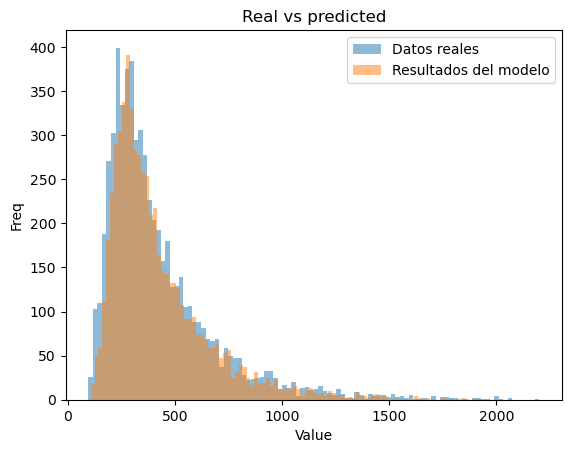

In [31]:
real_data = res["Real"]
model_data = res["Predict"]



plt.hist(real_data, bins=100, alpha=0.5, label='Datos reales')


plt.hist(model_data, bins=100, alpha=0.5, label='Resultados del modelo')


plt.xlabel('Value')
plt.ylabel('Freq')
plt.title('Real vs predicted')
plt.legend()

plt.show()


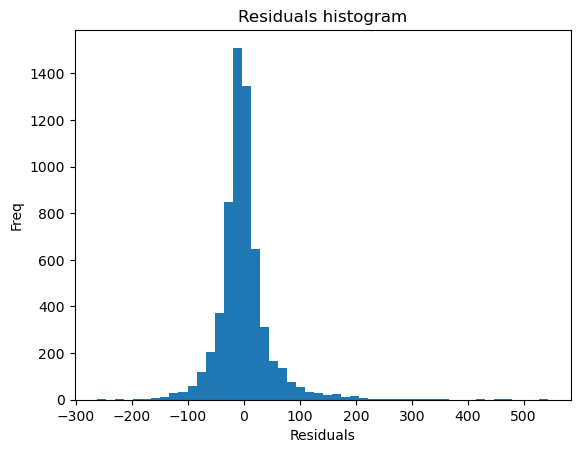

In [32]:
residuals = real_data - model_data

plt.hist(residuals, bins=50)


plt.xlabel('Residuals')
plt.ylabel('Freq')
plt.title('Residuals histogram')


plt.show()

## Classifier

In [53]:
merged_df["category"] = merged_df["realSum"].apply(lambda x: categorize_value(x))
merged_df.head()



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mcsalazart/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_14688/2727432628.py", line 1, in <module>
    merged_df["category"] = merged_df["realSum"].apply(lambda x: categorize_value(x))
  File "/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/series.py", line 4915, in apply
    ).apply()
  File "/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/apply.py", line 1427, in apply
    return self.apply_standard()
  File "/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/apply.py", line 1507, in apply_standard
    mapped = obj._map_values(
  File "/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/base.py", line 921, in _map_values
    return algorithms.map_array(arr, mapper, na_action=na_action, convert=convert)
  File "/home/mcsalazart/.local/lib/python3.10/site

In [34]:
X = merged_df.drop(['realSum','category'], axis=1)
y = merged_df['category']
stratify_col = 2 * preprocessing.LabelEncoder().fit_transform(X['city']) + preprocessing.LabelEncoder().fit_transform(X['is_weekend'])
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=TEST_DATASET_RATIO,
    random_state=SEED,
    shuffle=True,
    stratify=stratify_col
)


In [56]:
y_train

6313    Medium
2909      High
6625      High
4615       Low
6179    Medium
         ...  
460       High
2246    Medium
4139    Medium
3474      High
3631       Low
Name: category, Length: 6117, dtype: object

In [54]:
selected_columns = merged_df.columns[:10]

# Crea un nuevo DataFrame solo con las variables seleccionadas
selected_df = merged_df[selected_columns]

sns.pairplot(data=selected_df)

/home/mcsalazart/.local/lib/python3.10/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/home/mcsalazart/.local/lib/python3.10/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
/home/mcsalazart/.local/lib/python3.10/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/home/mcsalazart/.local/lib/python3.10/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
/home/mcsalazart/.

Error in callback <function flush_figures at 0x7f6bd3866710> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [36]:
model = pipeline.Pipeline([
    ('encoder', encoder),
    ('feat_select', None),
    ('classifier', None),
])

In [43]:
parameters = [
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_classif],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "classifier": [LinearDiscriminantAnalysis()],
        "classifier__solver": ['lsqr'],
        "classifier__shrinkage": [ 'auto', 0.1, 0.5, 1.0],
        
    },
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_classif],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "classifier": [LinearDiscriminantAnalysis()],
        "classifier__solver": ['svd'],
    
    },
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_classif],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "classifier": [QuadraticDiscriminantAnalysis()],
        "classifier__reg_param": [0.1],
    
    },
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_classif],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": [ 3, 5, 7, 10, 15, 20],
        "classifier__metric": ['euclidean', 'minkowski', 'manhattan'],
    
    },
        {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_classif],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "classifier": [GaussianNB()],
    
    },
            {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_classif],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "classifier": [LogisticRegressionCV(Cs=20, random_state=1, cv = 10, scoring = 'accuracy', multi_class='multinomial')],
    
    },
        {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_classif],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "classifier": [ensemble.RandomForestClassifier()],
        "classifier__n_estimators": [10, 50, 100],
        "classifier__min_samples_leaf": [ 5, 10],
        "classifier__max_features": [1, 'sqrt', 'log2'],
    },
    {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_classif],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "classifier": [svm.SVC()],
        "classifier__kernel": ['linear', 'rbf'],
        "classifier__C": [0.1, 1, 10],
        "classifier__gamma": ['scale'],
    },
#     {
#         "encoder__scaler": [preprocessing.StandardScaler()],
        
#         "feat_select": [feature_selection.GenericUnivariateSelect()],
#         "feat_select__score_func": [feature_selection.mutual_info_classif],
#         "feat_select__mode": ["k_best"],
#         "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
#         "classifier": [GradientBoostingClassifier()],
#         "classifier__n_estimators": [ 100, 200],
#         "classifier__learning_rate": [ 0.1, 0.2],
#         "classifier__max_depth": [5, 7],
#         "classifier__min_samples_leaf":[5],
#         "classifier__min_samples_split":[5]
        
#     },
        {
        "encoder__scaler": [preprocessing.StandardScaler()],
        
        "feat_select": [feature_selection.GenericUnivariateSelect()],
        "feat_select__score_func": [feature_selection.mutual_info_classif],
        "feat_select__mode": ["k_best"],
        "feat_select__param": [4, 7, 10, 15, 18, 'all'],
        
        "classifier": [Perceptron()],
        "classifier__penalty": [None, 'l2'],
        "classifier__alpha": [0.0001, 0.001],
        "classifier__max_iter": [1000, 2000, 3000],
    },
]

In [44]:
%%time
clf = model_selection.GridSearchCV(model, parameters, scoring='accuracy', cv=5, verbose=3, n_jobs=-1, error_score='raise')  # Stratified by default
clf.fit(X_train, y_train)

Fitting 5 folds for each of 372 candidates, totalling 1860 fits


/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mcsalazart/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from

[CV 4/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=auto, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.507 total time=   1.9s
[CV 1/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=auto, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.607 total time=   2.3s
[CV 5/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=auto, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.634 total time=   2.9

[CV 3/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=auto, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.516 total time=   2.3s
[CV 2/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=auto, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.630 total time=   2.4s
[CV 2/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=auto, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.640 total time=   2.

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("

[CV 2/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=1.0, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.599 total time=   2.1s
[CV 1/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=1.0, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.591 total time=   2.3s
[CV 5/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=1.0, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.591 total time=   1.6s

[CV 5/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=1.0, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.551 total time=   2.7s
[CV 4/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=1.0, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.617 total time=   1.9s
[CV 3/5] END classifier=LinearDiscriminantAnalysis(), classifier__shrinkage=1.0, classifier__solver=lsqr, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.612 total time=   2.4s

[CV 4/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=3, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.651 total time=   2.0s
[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=3, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.659 total time=   2.9s
[CV 2/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=3, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.635 total time=   2.4s


[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=3, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.665 total time=   1.9s
[CV 2/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=3, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.639 total time=   2.8s
[CV 1/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=3, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.649 total time=   2.5s


[CV 4/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.689 total time=   3.3s
[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.685 total time=   2.9s
[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.525 total time=   2.2

[CV 2/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.667 total time=   3.3s
[CV 1/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.677 total time=   3.5s
[CV 5/5] END classifier=KNeighborsClassifier(), classifier__metric=euclidean, classifier__n_neighbors=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.656 total time=   2

[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=3, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.642 total time=   4.0s
[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.527 total time=   3.6s
[CV 2/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.613 total time=   2.9s
[C

[CV 1/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.506 total time=   3.7s
[CV 5/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.539 total time=   4.0s
[CV 4/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.603 total time=   3.5s
[CV 

[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.525 total time=   2.0s
[CV 2/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.633 total time=   3.2s
[CV 4/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.657 total time=   2.5s
[

[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.634 total time=   3.2s
[CV 2/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.641 total time=   2.8s
[CV 1/5] END classifier=KNeighborsClassifier(), classifier__metric=minkowski, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.647 total time=   3.5s

[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.617 total time=   2.3s
[CV 1/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.633 total time=   2.4s
[CV 5/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.673 total time=   2.5s
[C

[CV 4/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.656 total time=   2.8s
[CV 4/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.692 total time=   3.4s
[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=5, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x7e25b770b5b0>;, score=0.686 total time=   3.2s
[

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

[CV 2/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.656 total time=   2.6s
[CV 1/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.679 total time=   2.9s
[CV 5/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.677 total time=   3.2

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

[CV 4/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.671 total time=   3.4s
[CV 3/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.665 total time=   3.5s
[CV 2/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.674 total time=   2.

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

[CV 1/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.672 total time=   3.6s
[CV 1/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.678 total time=   2.7s
[CV 4/5] END classifier=KNeighborsClassifier(), classifier__metric=manhattan, classifier__n_neighbors=15, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.679 total time=   3

/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcsalazart/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

[CV 3/5] END classifier=LogisticRegressionCV(Cs=20, cv=10, multi_class='multinomial', random_state=1,
                     scoring='accuracy'), encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.673 total time=  55.8s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=5, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.593 total time=   1.9s
[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=5, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, f

[CV 4/5] END classifier=LogisticRegressionCV(Cs=20, cv=10, multi_class='multinomial', random_state=1,
                     scoring='accuracy'), encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.684 total time=  56.3s
[CV 3/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=5, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.673 total time=   3.0s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=5, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15,

[CV 2/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.721 total time=   4.5s
[CV 1/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.703 total time=   4.6s
[CV 5/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, fe

[CV 1/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=10, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.632 total time=   2.5s
[CV 3/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=10, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.554 total time=   2.2s
[CV 3/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=10, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_

[CV 5/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.679 total time=   4.5s
[CV 5/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.708 total time=   4.5s
[CV 3/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, 

[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=1, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.684 total time=   3.8s
[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.600 total time=   2.7s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7

[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.709 total time=   6.1s
[CV 3/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.696 total time=   7.9s
[CV 3/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__para

[CV 2/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.717 total time=   6.0s
[CV 1/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=10, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.554 total time=   2.4s
[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=10, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__par

[CV 5/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.700 total time=   5.3s
[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.711 total time=   5.7s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__p

[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.702 total time=   6.4s
[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=sqrt, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.719 total time=   5.6s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__n_estimators=10, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__p

[CV 2/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.684 total time=   6.8s
[CV 1/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.681 total time=   6.9s
[CV 5/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__para

[CV 2/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.724 total time=   6.3s
[CV 1/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.714 total time=   6.5s
[CV 5/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__pa

[CV 1/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.658 total time=   5.4s
[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.675 total time=   5.5s
[CV 3/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__pa

[CV 1/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.685 total time=   6.5s
[CV 5/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.704 total time=   4.5s
[CV 4/5] END classifier=RandomForestClassifier(), classifier__max_features=log2, classifier__min_samples_leaf=10, classifier__n_estimators=100, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__

[CV 3/5] END classifier=SVC(), classifier__C=1, classifier__gamma=scale, classifier__kernel=linear, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.634 total time=   9.0s
[CV 2/5] END classifier=SVC(), classifier__C=1, classifier__gamma=scale, classifier__kernel=linear, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.658 total time=   9.8s
[CV 3/5] END classifier=SVC(), classifier__C=1, classifier__gamma=scale, classifier__kernel=linear, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.670 total time=   8.4s
[CV 1/5] END cla

[CV 1/5] END classifier=SVC(), classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.624 total time=   9.5s
[CV 5/5] END classifier=SVC(), classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.644 total time=   6.9s
[CV 4/5] END classifier=SVC(), classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x7c438bdbb5b0>;, score=0.654 total time=   7.5s
[CV 2/5] END classifier=SVC

[CV 4/5] END classifier=SVC(), classifier__C=10, classifier__gamma=scale, classifier__kernel=rbf, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.706 total time=   7.7s
[CV 3/5] END classifier=SVC(), classifier__C=10, classifier__gamma=scale, classifier__kernel=rbf, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.702 total time=   8.2s
[CV 2/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=1000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.510 total time=   1.8s
[CV

[CV 5/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=1000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.496 total time=   2.2s
[CV 4/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=1000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.533 total time=   2.4s
[CV 3/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=1000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>

[CV 5/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=2000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=18, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.542 total time=   2.7s
[CV 4/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=2000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.473 total time=   1.9s
[CV 3/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=2000, classifier__penalty=l2, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;

[CV 5/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=2000, classifier__penalty=l2, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.483 total time=   2.2s
[CV 4/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=2000, classifier__penalty=l2, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.513 total time=   2.4s
[CV 3/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=2000, classifier__penalty=l2, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, sco

[CV 2/5] END classifier=Perceptron(), classifier__alpha=0.0001, classifier__max_iter=3000, classifier__penalty=l2, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.583 total time=   2.8s
[CV 1/5] END classifier=Perceptron(), classifier__alpha=0.001, classifier__max_iter=1000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.437 total time=   1.6s
[CV 4/5] END classifier=Perceptron(), classifier__alpha=0.001, classifier__max_iter=1000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, s

[CV 5/5] END classifier=Perceptron(), classifier__alpha=0.001, classifier__max_iter=1000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.496 total time=   2.8s
[CV 4/5] END classifier=Perceptron(), classifier__alpha=0.001, classifier__max_iter=1000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=10, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, score=0.523 total time=   2.1s
[CV 3/5] END classifier=Perceptron(), classifier__alpha=0.001, classifier__max_iter=1000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=15, feat_select__score_func=<function mutual_info_classif at 0x794fd23bf5b0>;, 

[CV 2/5] END classifier=Perceptron(), classifier__alpha=0.001, classifier__max_iter=2000, classifier__penalty=None, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=all, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.613 total time=   2.3s
[CV 1/5] END classifier=Perceptron(), classifier__alpha=0.001, classifier__max_iter=2000, classifier__penalty=l2, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=4, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, score=0.400 total time=   1.9s
[CV 1/5] END classifier=Perceptron(), classifier__alpha=0.001, classifier__max_iter=2000, classifier__penalty=l2, encoder__scaler=StandardScaler(), feat_select=GenericUnivariateSelect(), feat_select__mode=k_best, feat_select__param=7, feat_select__score_func=<function mutual_info_classif at 0x74381370b5b0>;, scor

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         'scaler',
                                                                         Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm',
       'rest_index', 'rest_index_norm', 'lng', 'lat'],
      dtype='object')),
                                                                        ('...
                          'classifier__alpha': [0.0001, 0.001],
                          'classifier__max_iter': [1000, 2000, 3000],
                          'classifier__penalty': [None, 'l2'],
                          'encoder__scaler': [StandardScaler()],
                          'feat_select': [GenericUnivariateSelect()],
                          'feat_select__mode': ['k_best'],
                          'feat_select__param': [4, 7, 10, 15, 18, 'all'],
                          'feat_select__score_func': [<function mutual_info_classif at 0x7f6bbc268ca0>]}],
             scoring='accuracy', verbose=3)

In [45]:
clf.best_estimator_.get_params()

{'memory': None,
 'steps': [('encoder',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('scaler', StandardScaler(),
                                    Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
          'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm',
          'rest_index', 'rest_index_norm', 'lng', 'lat'],
         dtype='object')),
                                   ('onehotencoder-1',
                                    OneHotEncoder(drop='first',
                                                  sparse_output=False),
                                    Index(['room_type', 'city'], dtype='object')),
                                   ('onehotencoder-2',
                                    OneHotEncoder(drop='first',
                                                  sparse_output=False),
                                    Index(['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz'

In [46]:
clf.best_estimator_.score(X_train, y_train)

0.8922674513650483

In [47]:
res=pd.concat([pd.DataFrame(clf.predict(X_train)), y_train.reset_index(drop=True), X_train[['city', 'is_weekend']].reset_index(drop=True)], axis=1)
res.columns =['Predict', 'Real', 'City', 'is_weekend']

In [49]:


conf_mat = confusion_matrix(res["Real"], res["Predict"])
# print("Matriz de Confusión:")
print(conf_mat)


[[1880   63  138]
 [  37 1863  118]
 [ 147  156 1715]]
